# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_top_{N}.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_ablated_top_{N}.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

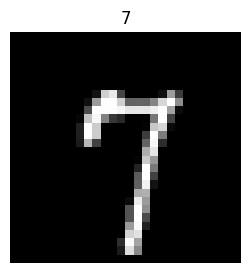

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [15]:
loss_factors = np.arange(0.0, 0.01 + 0.001, 0.001)
print(len(loss_factors))

11


In [16]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.0




Epoch 1/20
  Train Loss: 1.0223
  SAE Train Loss (hidden one): 8.8025
  SAE Train Loss (hidden two): 1.1771
  Val Loss: 0.5656 | Val Acc: 83.62%
  Saved model with Val Acc: 83.62%


Epoch 2/20
  Train Loss: 0.4646
  SAE Train Loss (hidden one): 0.5374
  SAE Train Loss (hidden two): 0.1031
  Val Loss: 0.4460 | Val Acc: 86.46%
  Saved model with Val Acc: 86.46%


Epoch 3/20
  Train Loss: 0.3924
  SAE Train Loss (hidden one): 0.5168
  SAE Train Loss (hidden two): 0.0914
  Val Loss: 0.3987 | Val Acc: 88.16%
  Saved model with Val Acc: 88.16%


Epoch 4/20
  Train Loss: 0.3673
  SAE Train Loss (hidden one): 0.5392
  SAE Train Loss (hidden two): 0.0826
  Val Loss: 0.3996 | Val Acc: 88.18%
  Saved model with Val Acc: 88.18%


Epoch 5/20
  Train Loss: 0.3517
  SAE Train Loss (hidden one): 0.5301
  SAE Train Loss (hidden two): 0.0762
  Val Loss: 0.3552 | Val Acc: 89.42%
  Saved model with Val Acc: 89.42%


Epoch 6/20
  Train Loss: 0.3349
  SAE Train Loss (hidden one): 0.5936
  SAE Train Loss (hidden two): 0.0750
  Val Loss: 0.3484 | Val Acc: 89.91%
  Saved model with Val Acc: 89.91%


Epoch 7/20
  Train Loss: 0.3278
  SAE Train Loss (hidden one): 0.6069
  SAE Train Loss (hidden two): 0.0731
  Val Loss: 0.3521 | Val Acc: 89.77%


Epoch 8/20
  Train Loss: 0.3185
  SAE Train Loss (hidden one): 0.6247
  SAE Train Loss (hidden two): 0.0704
  Val Loss: 0.3430 | Val Acc: 89.99%
  Saved model with Val Acc: 89.99%


Epoch 9/20
  Train Loss: 0.3092
  SAE Train Loss (hidden one): 0.6384
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3521 | Val Acc: 89.41%


Epoch 10/20
  Train Loss: 0.3059
  SAE Train Loss (hidden one): 0.6079
  SAE Train Loss (hidden two): 0.0648
  Val Loss: 0.3405 | Val Acc: 90.10%
  Saved model with Val Acc: 90.10%


Epoch 11/20
  Train Loss: 0.2975
  SAE Train Loss (hidden one): 0.5902
  SAE Train Loss (hidden two): 0.0635
  Val Loss: 0.3421 | Val Acc: 90.39%
  Saved model with Val Acc: 90.39%


Epoch 12/20
  Train Loss: 0.2959
  SAE Train Loss (hidden one): 0.6767
  SAE Train Loss (hidden two): 0.0629
  Val Loss: 0.3340 | Val Acc: 90.59%
  Saved model with Val Acc: 90.59%


Epoch 13/20
  Train Loss: 0.2922
  SAE Train Loss (hidden one): 0.6343
  SAE Train Loss (hidden two): 0.0592
  Val Loss: 0.3310 | Val Acc: 90.67%
  Saved model with Val Acc: 90.67%


Epoch 14/20
  Train Loss: 0.2875
  SAE Train Loss (hidden one): 0.6153
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.3456 | Val Acc: 89.83%


Epoch 15/20
  Train Loss: 0.2879
  SAE Train Loss (hidden one): 0.6247
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3609 | Val Acc: 89.51%


Epoch 16/20
  Train Loss: 0.2835
  SAE Train Loss (hidden one): 0.6209
  SAE Train Loss (hidden two): 0.0530
  Val Loss: 0.3243 | Val Acc: 90.88%
  Saved model with Val Acc: 90.88%


Epoch 17/20
  Train Loss: 0.2821
  SAE Train Loss (hidden one): 0.6050
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3349 | Val Acc: 90.67%


Epoch 18/20
  Train Loss: 0.2784
  SAE Train Loss (hidden one): 0.6636
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3256 | Val Acc: 90.95%
  Saved model with Val Acc: 90.95%


Epoch 19/20
  Train Loss: 0.2754
  SAE Train Loss (hidden one): 0.6143
  SAE Train Loss (hidden two): 0.0501
  Val Loss: 0.3458 | Val Acc: 89.98%


Epoch 20/20
  Train Loss: 0.2749
  SAE Train Loss (hidden one): 0.6182
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.3339 | Val Acc: 90.36%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 267.98it/s]


Final Test Accuracy: 91.11%
Average Reconstruction Error (Hidden One): 0.1686
Average Reconstruction Error (Hidden Two): 0.0237
Average Non-Zero Features per Image (Hidden One): 32.81
Average Non-Zero Features per Image (Hidden Two): 33.70


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.40%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.68%

##################################################
Loss factor: 0.001




Epoch 1/20
  Train Loss: 1.0280
  SAE Train Loss (hidden one): 8.6243
  SAE Train Loss (hidden two): 1.1437
  Val Loss: 0.5353 | Val Acc: 84.60%
  Saved model with Val Acc: 84.60%


Epoch 2/20
  Train Loss: 0.4583
  SAE Train Loss (hidden one): 0.4240
  SAE Train Loss (hidden two): 0.0928
  Val Loss: 0.4192 | Val Acc: 87.65%
  Saved model with Val Acc: 87.65%


Epoch 3/20
  Train Loss: 0.3990
  SAE Train Loss (hidden one): 0.4501
  SAE Train Loss (hidden two): 0.0784
  Val Loss: 0.4167 | Val Acc: 87.76%
  Saved model with Val Acc: 87.76%


Epoch 4/20
  Train Loss: 0.3780
  SAE Train Loss (hidden one): 0.4629
  SAE Train Loss (hidden two): 0.0692
  Val Loss: 0.3790 | Val Acc: 88.70%
  Saved model with Val Acc: 88.70%


Epoch 5/20
  Train Loss: 0.3649
  SAE Train Loss (hidden one): 0.4758
  SAE Train Loss (hidden two): 0.0655
  Val Loss: 0.3741 | Val Acc: 88.89%
  Saved model with Val Acc: 88.89%


Epoch 6/20
  Train Loss: 0.3578
  SAE Train Loss (hidden one): 0.4915
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3737 | Val Acc: 89.11%
  Saved model with Val Acc: 89.11%


Epoch 7/20
  Train Loss: 0.3522
  SAE Train Loss (hidden one): 0.5442
  SAE Train Loss (hidden two): 0.0582
  Val Loss: 0.3853 | Val Acc: 88.79%


Epoch 8/20
  Train Loss: 0.3466
  SAE Train Loss (hidden one): 0.5624
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.3663 | Val Acc: 88.94%


Epoch 9/20
  Train Loss: 0.3399
  SAE Train Loss (hidden one): 0.5967
  SAE Train Loss (hidden two): 0.0565
  Val Loss: 0.3775 | Val Acc: 88.66%


Epoch 10/20
  Train Loss: 0.3359
  SAE Train Loss (hidden one): 0.5097
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.3706 | Val Acc: 88.95%


Epoch 11/20
  Train Loss: 0.3317
  SAE Train Loss (hidden one): 0.6324
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.3865 | Val Acc: 88.44%


Epoch 12/20
  Train Loss: 0.3297
  SAE Train Loss (hidden one): 0.5368
  SAE Train Loss (hidden two): 0.0496
  Val Loss: 0.3648 | Val Acc: 89.04%


Epoch 13/20
  Train Loss: 0.3259
  SAE Train Loss (hidden one): 0.5496
  SAE Train Loss (hidden two): 0.0497
  Val Loss: 0.3569 | Val Acc: 89.46%
  Saved model with Val Acc: 89.46%


Epoch 14/20
  Train Loss: 0.3241
  SAE Train Loss (hidden one): 0.6137
  SAE Train Loss (hidden two): 0.0490
  Val Loss: 0.3543 | Val Acc: 89.40%


Epoch 15/20
  Train Loss: 0.3247
  SAE Train Loss (hidden one): 0.5164
  SAE Train Loss (hidden two): 0.0471
  Val Loss: 0.3511 | Val Acc: 89.27%


Epoch 16/20
  Train Loss: 0.3200
  SAE Train Loss (hidden one): 0.6072
  SAE Train Loss (hidden two): 0.0465
  Val Loss: 0.3524 | Val Acc: 89.55%
  Saved model with Val Acc: 89.55%


Epoch 17/20
  Train Loss: 0.3207
  SAE Train Loss (hidden one): 0.6231
  SAE Train Loss (hidden two): 0.0466
  Val Loss: 0.3488 | Val Acc: 89.70%
  Saved model with Val Acc: 89.70%


Epoch 18/20
  Train Loss: 0.3208
  SAE Train Loss (hidden one): 0.6501
  SAE Train Loss (hidden two): 0.0464
  Val Loss: 0.3489 | Val Acc: 89.55%


Epoch 19/20
  Train Loss: 0.3147
  SAE Train Loss (hidden one): 0.5385
  SAE Train Loss (hidden two): 0.0446
  Val Loss: 0.3618 | Val Acc: 89.29%


Epoch 20/20
  Train Loss: 0.3154
  SAE Train Loss (hidden one): 0.5415
  SAE Train Loss (hidden two): 0.0451
  Val Loss: 0.3576 | Val Acc: 89.59%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 277.40it/s]


Final Test Accuracy: 89.91%
Average Reconstruction Error (Hidden One): 0.8298
Average Reconstruction Error (Hidden Two): 0.0187
Average Non-Zero Features per Image (Hidden One): 32.79
Average Non-Zero Features per Image (Hidden Two): 33.70


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 87.68%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.20%

##################################################
Loss factor: 0.002




Epoch 1/20
  Train Loss: 1.0179
  SAE Train Loss (hidden one): 8.6718
  SAE Train Loss (hidden two): 1.1493
  Val Loss: 0.5084 | Val Acc: 84.81%
  Saved model with Val Acc: 84.81%


Epoch 2/20
  Train Loss: 0.4559
  SAE Train Loss (hidden one): 0.4654
  SAE Train Loss (hidden two): 0.0953
  Val Loss: 0.4211 | Val Acc: 87.56%
  Saved model with Val Acc: 87.56%


Epoch 3/20
  Train Loss: 0.3960
  SAE Train Loss (hidden one): 0.4863
  SAE Train Loss (hidden two): 0.0812
  Val Loss: 0.4135 | Val Acc: 87.82%
  Saved model with Val Acc: 87.82%


Epoch 4/20
  Train Loss: 0.3710
  SAE Train Loss (hidden one): 0.5520
  SAE Train Loss (hidden two): 0.0741
  Val Loss: 0.3752 | Val Acc: 88.86%
  Saved model with Val Acc: 88.86%


Epoch 5/20
  Train Loss: 0.3542
  SAE Train Loss (hidden one): 0.5806
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.3486 | Val Acc: 89.59%
  Saved model with Val Acc: 89.59%


Epoch 6/20
  Train Loss: 0.3358
  SAE Train Loss (hidden one): 0.6257
  SAE Train Loss (hidden two): 0.0700
  Val Loss: 0.3492 | Val Acc: 90.05%
  Saved model with Val Acc: 90.05%


Epoch 7/20
  Train Loss: 0.3265
  SAE Train Loss (hidden one): 0.6661
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3518 | Val Acc: 90.06%
  Saved model with Val Acc: 90.06%


Epoch 8/20
  Train Loss: 0.3202
  SAE Train Loss (hidden one): 0.6725
  SAE Train Loss (hidden two): 0.0654
  Val Loss: 0.3378 | Val Acc: 90.02%


Epoch 9/20
  Train Loss: 0.3138
  SAE Train Loss (hidden one): 0.6965
  SAE Train Loss (hidden two): 0.0649
  Val Loss: 0.3535 | Val Acc: 89.48%


Epoch 10/20
  Train Loss: 0.3073
  SAE Train Loss (hidden one): 0.6875
  SAE Train Loss (hidden two): 0.0616
  Val Loss: 0.3430 | Val Acc: 89.91%


Epoch 11/20
  Train Loss: 0.3016
  SAE Train Loss (hidden one): 0.6944
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.3444 | Val Acc: 90.12%
  Saved model with Val Acc: 90.12%


Epoch 12/20
  Train Loss: 0.2964
  SAE Train Loss (hidden one): 0.7158
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.3266 | Val Acc: 90.21%
  Saved model with Val Acc: 90.21%


Epoch 13/20
  Train Loss: 0.2928
  SAE Train Loss (hidden one): 0.6897
  SAE Train Loss (hidden two): 0.0589
  Val Loss: 0.3402 | Val Acc: 90.18%


Epoch 14/20
  Train Loss: 0.2882
  SAE Train Loss (hidden one): 0.6722
  SAE Train Loss (hidden two): 0.0588
  Val Loss: 0.3236 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 15/20
  Train Loss: 0.2830
  SAE Train Loss (hidden one): 0.6221
  SAE Train Loss (hidden two): 0.0564
  Val Loss: 0.3304 | Val Acc: 90.68%


Epoch 16/20
  Train Loss: 0.2810
  SAE Train Loss (hidden one): 0.7905
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3109 | Val Acc: 91.00%
  Saved model with Val Acc: 91.00%


Epoch 17/20
  Train Loss: 0.2758
  SAE Train Loss (hidden one): 0.6914
  SAE Train Loss (hidden two): 0.0579
  Val Loss: 0.3113 | Val Acc: 90.99%


Epoch 18/20
  Train Loss: 0.2739
  SAE Train Loss (hidden one): 0.6319
  SAE Train Loss (hidden two): 0.0553
  Val Loss: 0.3027 | Val Acc: 91.25%
  Saved model with Val Acc: 91.25%


Epoch 19/20
  Train Loss: 0.2700
  SAE Train Loss (hidden one): 0.6834
  SAE Train Loss (hidden two): 0.0539
  Val Loss: 0.3229 | Val Acc: 90.19%


Epoch 20/20
  Train Loss: 0.2662
  SAE Train Loss (hidden one): 0.6671
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3200 | Val Acc: 90.55%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 264.79it/s]

Final Test Accuracy: 91.74%
Average Reconstruction Error (Hidden One): 0.5619
Average Reconstruction Error (Hidden Two): 0.0242
Average Non-Zero Features per Image (Hidden One): 33.09
Average Non-Zero Features per Image (Hidden Two): 33.64



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.53%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.36%

##################################################
Loss factor: 0.003




Epoch 1/20
  Train Loss: 1.0750
  SAE Train Loss (hidden one): 8.1960
  SAE Train Loss (hidden two): 1.1234
  Val Loss: 0.6791 | Val Acc: 81.24%
  Saved model with Val Acc: 81.24%


Epoch 2/20
  Train Loss: 0.5748
  SAE Train Loss (hidden one): 0.4461
  SAE Train Loss (hidden two): 0.0961
  Val Loss: 0.4929 | Val Acc: 86.18%
  Saved model with Val Acc: 86.18%


Epoch 3/20
  Train Loss: 0.4614
  SAE Train Loss (hidden one): 0.4719
  SAE Train Loss (hidden two): 0.0786
  Val Loss: 0.4526 | Val Acc: 87.34%
  Saved model with Val Acc: 87.34%


Epoch 4/20
  Train Loss: 0.4273
  SAE Train Loss (hidden one): 0.5281
  SAE Train Loss (hidden two): 0.0717
  Val Loss: 0.3948 | Val Acc: 88.79%
  Saved model with Val Acc: 88.79%


Epoch 5/20
  Train Loss: 0.4024
  SAE Train Loss (hidden one): 0.4080
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.4211 | Val Acc: 88.15%


Epoch 6/20
  Train Loss: 0.3919
  SAE Train Loss (hidden one): 0.4570
  SAE Train Loss (hidden two): 0.0596
  Val Loss: 0.3922 | Val Acc: 88.50%


Epoch 7/20
  Train Loss: 0.3872
  SAE Train Loss (hidden one): 0.4491
  SAE Train Loss (hidden two): 0.0559
  Val Loss: 0.4273 | Val Acc: 87.91%


Epoch 8/20
  Train Loss: 0.3831
  SAE Train Loss (hidden one): 0.4885
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.4198 | Val Acc: 87.81%


Epoch 9/20
  Train Loss: 0.3683
  SAE Train Loss (hidden one): 0.5427
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.3849 | Val Acc: 88.96%
  Saved model with Val Acc: 88.96%


Epoch 10/20
  Train Loss: 0.3622
  SAE Train Loss (hidden one): 0.4411
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.3804 | Val Acc: 88.72%


Epoch 11/20
  Train Loss: 0.3587
  SAE Train Loss (hidden one): 0.5215
  SAE Train Loss (hidden two): 0.0511
  Val Loss: 0.3672 | Val Acc: 89.12%
  Saved model with Val Acc: 89.12%


Epoch 12/20
  Train Loss: 0.3582
  SAE Train Loss (hidden one): 0.5333
  SAE Train Loss (hidden two): 0.0481
  Val Loss: 0.3879 | Val Acc: 88.72%


Epoch 13/20
  Train Loss: 0.3572
  SAE Train Loss (hidden one): 0.6345
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.3680 | Val Acc: 89.32%
  Saved model with Val Acc: 89.32%


Epoch 14/20
  Train Loss: 0.3495
  SAE Train Loss (hidden one): 0.4448
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.3729 | Val Acc: 89.30%


Epoch 15/20
  Train Loss: 0.3472
  SAE Train Loss (hidden one): 0.5247
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.3609 | Val Acc: 89.27%


Epoch 16/20
  Train Loss: 0.3384
  SAE Train Loss (hidden one): 0.5654
  SAE Train Loss (hidden two): 0.0459
  Val Loss: 0.3592 | Val Acc: 89.60%
  Saved model with Val Acc: 89.60%


Epoch 17/20
  Train Loss: 0.3375
  SAE Train Loss (hidden one): 0.5112
  SAE Train Loss (hidden two): 0.0437
  Val Loss: 0.3663 | Val Acc: 89.40%


Epoch 18/20
  Train Loss: 0.3347
  SAE Train Loss (hidden one): 0.5467
  SAE Train Loss (hidden two): 0.0427
  Val Loss: 0.3556 | Val Acc: 89.62%
  Saved model with Val Acc: 89.62%


Epoch 19/20
  Train Loss: 0.3287
  SAE Train Loss (hidden one): 0.5284
  SAE Train Loss (hidden two): 0.0426
  Val Loss: 0.3642 | Val Acc: 89.43%


Epoch 20/20
  Train Loss: 0.3276
  SAE Train Loss (hidden one): 0.5489
  SAE Train Loss (hidden two): 0.0422
  Val Loss: 0.3577 | Val Acc: 89.97%
  Saved model with Val Acc: 89.97%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 264.26it/s]


Final Test Accuracy: 89.83%
Average Reconstruction Error (Hidden One): 0.3793
Average Reconstruction Error (Hidden Two): 0.0204
Average Non-Zero Features per Image (Hidden One): 30.86
Average Non-Zero Features per Image (Hidden Two): 32.21


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.11%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.91%

##################################################
Loss factor: 0.004




Epoch 1/20
  Train Loss: 1.0760
  SAE Train Loss (hidden one): 8.4559
  SAE Train Loss (hidden two): 1.1412
  Val Loss: 0.6304 | Val Acc: 82.19%
  Saved model with Val Acc: 82.19%


Epoch 2/20
  Train Loss: 0.4953
  SAE Train Loss (hidden one): 0.6361
  SAE Train Loss (hidden two): 0.1102
  Val Loss: 0.5129 | Val Acc: 84.19%
  Saved model with Val Acc: 84.19%


Epoch 3/20
  Train Loss: 0.4097
  SAE Train Loss (hidden one): 0.5824
  SAE Train Loss (hidden two): 0.0900
  Val Loss: 0.4077 | Val Acc: 87.93%
  Saved model with Val Acc: 87.93%


Epoch 4/20
  Train Loss: 0.3671
  SAE Train Loss (hidden one): 0.6475
  SAE Train Loss (hidden two): 0.0898
  Val Loss: 0.3587 | Val Acc: 89.63%
  Saved model with Val Acc: 89.63%


Epoch 5/20
  Train Loss: 0.3450
  SAE Train Loss (hidden one): 0.6266
  SAE Train Loss (hidden two): 0.0825
  Val Loss: 0.3393 | Val Acc: 90.05%
  Saved model with Val Acc: 90.05%


Epoch 6/20
  Train Loss: 0.3307
  SAE Train Loss (hidden one): 0.5973
  SAE Train Loss (hidden two): 0.0782
  Val Loss: 0.3479 | Val Acc: 90.25%
  Saved model with Val Acc: 90.25%


Epoch 7/20
  Train Loss: 0.3208
  SAE Train Loss (hidden one): 0.5608
  SAE Train Loss (hidden two): 0.0734
  Val Loss: 0.3477 | Val Acc: 90.06%


Epoch 8/20
  Train Loss: 0.3175
  SAE Train Loss (hidden one): 0.5801
  SAE Train Loss (hidden two): 0.0706
  Val Loss: 0.3444 | Val Acc: 89.92%


Epoch 9/20
  Train Loss: 0.3064
  SAE Train Loss (hidden one): 0.5945
  SAE Train Loss (hidden two): 0.0696
  Val Loss: 0.3443 | Val Acc: 89.67%


Epoch 10/20
  Train Loss: 0.3043
  SAE Train Loss (hidden one): 0.5157
  SAE Train Loss (hidden two): 0.0656
  Val Loss: 0.3601 | Val Acc: 89.66%


Epoch 11/20
  Train Loss: 0.2960
  SAE Train Loss (hidden one): 0.6168
  SAE Train Loss (hidden two): 0.0652
  Val Loss: 0.3363 | Val Acc: 90.06%


Epoch 12/20
  Train Loss: 0.2981
  SAE Train Loss (hidden one): 0.6473
  SAE Train Loss (hidden two): 0.0643
  Val Loss: 0.3145 | Val Acc: 90.92%
  Saved model with Val Acc: 90.92%


Epoch 13/20
  Train Loss: 0.2888
  SAE Train Loss (hidden one): 0.7153
  SAE Train Loss (hidden two): 0.0675
  Val Loss: 0.3073 | Val Acc: 90.83%


Epoch 14/20
  Train Loss: 0.2883
  SAE Train Loss (hidden one): 0.6020
  SAE Train Loss (hidden two): 0.0612
  Val Loss: 0.3115 | Val Acc: 90.87%


Epoch 15/20
  Train Loss: 0.2835
  SAE Train Loss (hidden one): 0.6830
  SAE Train Loss (hidden two): 0.0632
  Val Loss: 0.3514 | Val Acc: 90.02%


Epoch 16/20
  Train Loss: 0.2780
  SAE Train Loss (hidden one): 0.7445
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.3064 | Val Acc: 91.14%
  Saved model with Val Acc: 91.14%


Epoch 17/20
  Train Loss: 0.2739
  SAE Train Loss (hidden one): 0.7355
  SAE Train Loss (hidden two): 0.0601
  Val Loss: 0.2964 | Val Acc: 91.58%
  Saved model with Val Acc: 91.58%


Epoch 18/20
  Train Loss: 0.2680
  SAE Train Loss (hidden one): 0.6496
  SAE Train Loss (hidden two): 0.0565
  Val Loss: 0.2998 | Val Acc: 91.26%


Epoch 19/20
  Train Loss: 0.2647
  SAE Train Loss (hidden one): 0.8207
  SAE Train Loss (hidden two): 0.0573
  Val Loss: 0.3086 | Val Acc: 91.02%


Epoch 20/20
  Train Loss: 0.2624
  SAE Train Loss (hidden one): 0.6460
  SAE Train Loss (hidden two): 0.0546
  Val Loss: 0.3011 | Val Acc: 91.25%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 253.47it/s]

Final Test Accuracy: 91.17%
Average Reconstruction Error (Hidden One): 0.1337
Average Reconstruction Error (Hidden Two): 0.0193
Average Non-Zero Features per Image (Hidden One): 33.88
Average Non-Zero Features per Image (Hidden Two): 34.59



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.57%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.97%

##################################################
Loss factor: 0.005




Epoch 1/20
  Train Loss: 1.0321
  SAE Train Loss (hidden one): 8.9207
  SAE Train Loss (hidden two): 1.1793
  Val Loss: 0.5022 | Val Acc: 85.67%
  Saved model with Val Acc: 85.67%


Epoch 2/20
  Train Loss: 0.4558
  SAE Train Loss (hidden one): 0.5850
  SAE Train Loss (hidden two): 0.1058
  Val Loss: 0.4100 | Val Acc: 88.71%
  Saved model with Val Acc: 88.71%


Epoch 3/20
  Train Loss: 0.3599
  SAE Train Loss (hidden one): 0.5582
  SAE Train Loss (hidden two): 0.0902
  Val Loss: 0.3477 | Val Acc: 89.88%
  Saved model with Val Acc: 89.88%


Epoch 4/20
  Train Loss: 0.3277
  SAE Train Loss (hidden one): 0.5476
  SAE Train Loss (hidden two): 0.0804
  Val Loss: 0.3138 | Val Acc: 90.97%
  Saved model with Val Acc: 90.97%


Epoch 5/20
  Train Loss: 0.3061
  SAE Train Loss (hidden one): 0.5226
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3153 | Val Acc: 91.17%
  Saved model with Val Acc: 91.17%


Epoch 6/20
  Train Loss: 0.2924
  SAE Train Loss (hidden one): 0.5691
  SAE Train Loss (hidden two): 0.0712
  Val Loss: 0.3005 | Val Acc: 91.38%
  Saved model with Val Acc: 91.38%


Epoch 7/20
  Train Loss: 0.2855
  SAE Train Loss (hidden one): 0.5665
  SAE Train Loss (hidden two): 0.0698
  Val Loss: 0.2988 | Val Acc: 91.33%


Epoch 8/20
  Train Loss: 0.2781
  SAE Train Loss (hidden one): 0.5864
  SAE Train Loss (hidden two): 0.0662
  Val Loss: 0.2993 | Val Acc: 91.29%


Epoch 9/20
  Train Loss: 0.2706
  SAE Train Loss (hidden one): 0.6592
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3223 | Val Acc: 90.60%


Epoch 10/20
  Train Loss: 0.2674
  SAE Train Loss (hidden one): 0.5729
  SAE Train Loss (hidden two): 0.0632
  Val Loss: 0.2942 | Val Acc: 91.38%
  Saved model with same Val Acc: 91.38% but lower Val Loss: 0.2942


Epoch 11/20
  Train Loss: 0.2612
  SAE Train Loss (hidden one): 0.6400
  SAE Train Loss (hidden two): 0.0609
  Val Loss: 0.2949 | Val Acc: 91.40%
  Saved model with Val Acc: 91.40%


Epoch 12/20
  Train Loss: 0.2564
  SAE Train Loss (hidden one): 0.6402
  SAE Train Loss (hidden two): 0.0586
  Val Loss: 0.2838 | Val Acc: 91.80%
  Saved model with Val Acc: 91.80%


Epoch 13/20
  Train Loss: 0.2517
  SAE Train Loss (hidden one): 0.6676
  SAE Train Loss (hidden two): 0.0572
  Val Loss: 0.2804 | Val Acc: 91.94%
  Saved model with Val Acc: 91.94%


Epoch 14/20
  Train Loss: 0.2490
  SAE Train Loss (hidden one): 0.6386
  SAE Train Loss (hidden two): 0.0556
  Val Loss: 0.2931 | Val Acc: 91.60%


Epoch 15/20
  Train Loss: 0.2474
  SAE Train Loss (hidden one): 0.6178
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.2886 | Val Acc: 91.57%


Epoch 16/20
  Train Loss: 0.2440
  SAE Train Loss (hidden one): 0.6060
  SAE Train Loss (hidden two): 0.0520
  Val Loss: 0.2726 | Val Acc: 92.18%
  Saved model with Val Acc: 92.18%


Epoch 17/20
  Train Loss: 0.2406
  SAE Train Loss (hidden one): 0.6762
  SAE Train Loss (hidden two): 0.0509
  Val Loss: 0.2792 | Val Acc: 92.15%


Epoch 18/20
  Train Loss: 0.2381
  SAE Train Loss (hidden one): 0.6554
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.2692 | Val Acc: 92.34%
  Saved model with Val Acc: 92.34%


Epoch 19/20
  Train Loss: 0.2396
  SAE Train Loss (hidden one): 0.5604
  SAE Train Loss (hidden two): 0.0473
  Val Loss: 0.2960 | Val Acc: 91.49%


Epoch 20/20
  Train Loss: 0.2364
  SAE Train Loss (hidden one): 0.6975
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.2923 | Val Acc: 91.69%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 271.01it/s]


Final Test Accuracy: 92.33%
Average Reconstruction Error (Hidden One): 0.1816
Average Reconstruction Error (Hidden Two): 0.0155
Average Non-Zero Features per Image (Hidden One): 33.34
Average Non-Zero Features per Image (Hidden Two): 33.89


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.75%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.26%

##################################################
Loss factor: 0.006




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2770
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0694
  Val Loss: 0.3147 | Val Acc: 90.77%


Epoch 12/20
  Train Loss: 0.2746
  SAE Train Loss (hidden one): 0.7142
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.3075 | Val Acc: 91.30%
  Saved model with Val Acc: 91.30%


Epoch 13/20
  Train Loss: 0.2717
  SAE Train Loss (hidden one): 0.6547
  SAE Train Loss (hidden two): 0.0651
  Val Loss: 0.2922 | Val Acc: 91.30%
  Saved model with same Val Acc: 91.30% but lower Val Loss: 0.2922


Epoch 14/20
  Train Loss: 0.2669
  SAE Train Loss (hidden one): 0.6568
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.3136 | Val Acc: 91.04%


Epoch 15/20
  Train Loss: 0.2636
  SAE Train Loss (hidden one): 0.7586
  SAE Train Loss (hidden two): 0.0617
  Val Loss: 0.3038 | Val Acc: 91.40%
  Saved model with Val Acc: 91.40%


Epoch 16/20
  Train Loss: 0.2632
  SAE Train Loss (hidden one): 0.6630
  SAE Train Loss (hidden two): 0.0601
  Val Loss: 0.3094 | Val Acc: 91.15%


Epoch 17/20
  Train Loss: 0.2565
  SAE Train Loss (hidden one): 0.6985
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.3043 | Val Acc: 91.18%


Epoch 18/20
  Train Loss: 0.2605
  SAE Train Loss (hidden one): 0.7256
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.2915 | Val Acc: 91.61%
  Saved model with Val Acc: 91.61%


Epoch 19/20
  Train Loss: 0.2548
  SAE Train Loss (hidden one): 0.8211
  SAE Train Loss (hidden two): 0.0546
  Val Loss: 0.2921 | Val Acc: 91.75%
  Saved model with Val Acc: 91.75%


Epoch 20/20
  Train Loss: 0.2510
  SAE Train Loss (hidden one): 0.7354
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3026 | Val Acc: 91.43%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 249.81it/s]

Final Test Accuracy: 92.00%
Average Reconstruction Error (Hidden One): 0.1415
Average Reconstruction Error (Hidden Two): 0.0141
Average Non-Zero Features per Image (Hidden One): 33.41
Average Non-Zero Features per Image (Hidden Two): 35.17



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.29%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.07%

##################################################
Loss factor: 0.007




Epoch 1/20
  Train Loss: 1.0610
  SAE Train Loss (hidden one): 8.5880
  SAE Train Loss (hidden two): 1.1712
  Val Loss: 0.6592 | Val Acc: 83.05%
  Saved model with Val Acc: 83.05%


Epoch 2/20
  Train Loss: 0.5262
  SAE Train Loss (hidden one): 0.5420
  SAE Train Loss (hidden two): 0.1119
  Val Loss: 0.5060 | Val Acc: 85.68%
  Saved model with Val Acc: 85.68%


Epoch 3/20
  Train Loss: 0.4080
  SAE Train Loss (hidden one): 0.5400
  SAE Train Loss (hidden two): 0.0921
  Val Loss: 0.4207 | Val Acc: 88.05%
  Saved model with Val Acc: 88.05%


Epoch 4/20
  Train Loss: 0.3691
  SAE Train Loss (hidden one): 0.5556
  SAE Train Loss (hidden two): 0.0839
  Val Loss: 0.3786 | Val Acc: 89.24%
  Saved model with Val Acc: 89.24%


Epoch 5/20
  Train Loss: 0.3486
  SAE Train Loss (hidden one): 0.5034
  SAE Train Loss (hidden two): 0.0755
  Val Loss: 0.3645 | Val Acc: 89.19%


Epoch 6/20
  Train Loss: 0.3300
  SAE Train Loss (hidden one): 0.5188
  SAE Train Loss (hidden two): 0.0698
  Val Loss: 0.3411 | Val Acc: 90.24%
  Saved model with Val Acc: 90.24%


Epoch 7/20
  Train Loss: 0.3209
  SAE Train Loss (hidden one): 0.5081
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3487 | Val Acc: 89.99%


Epoch 8/20
  Train Loss: 0.3164
  SAE Train Loss (hidden one): 0.5276
  SAE Train Loss (hidden two): 0.0620
  Val Loss: 0.3706 | Val Acc: 89.88%


Epoch 9/20
  Train Loss: 0.3087
  SAE Train Loss (hidden one): 0.5634
  SAE Train Loss (hidden two): 0.0602
  Val Loss: 0.3469 | Val Acc: 89.79%


Epoch 10/20
  Train Loss: 0.3044
  SAE Train Loss (hidden one): 0.4591
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.3429 | Val Acc: 90.00%


Epoch 11/20
  Train Loss: 0.3008
  SAE Train Loss (hidden one): 0.5448
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.3272 | Val Acc: 90.63%
  Saved model with Val Acc: 90.63%


Epoch 12/20
  Train Loss: 0.2953
  SAE Train Loss (hidden one): 0.5099
  SAE Train Loss (hidden two): 0.0511
  Val Loss: 0.3326 | Val Acc: 90.21%


Epoch 13/20
  Train Loss: 0.2936
  SAE Train Loss (hidden one): 0.5662
  SAE Train Loss (hidden two): 0.0503
  Val Loss: 0.3301 | Val Acc: 90.74%
  Saved model with Val Acc: 90.74%


Epoch 14/20
  Train Loss: 0.2884
  SAE Train Loss (hidden one): 0.5538
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.3274 | Val Acc: 90.69%


Epoch 15/20
  Train Loss: 0.2886
  SAE Train Loss (hidden one): 0.5485
  SAE Train Loss (hidden two): 0.0459
  Val Loss: 0.3378 | Val Acc: 90.40%


Epoch 16/20
  Train Loss: 0.2848
  SAE Train Loss (hidden one): 0.5685
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.3248 | Val Acc: 90.52%


Epoch 17/20
  Train Loss: 0.2831
  SAE Train Loss (hidden one): 0.6054
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.3162 | Val Acc: 90.79%
  Saved model with Val Acc: 90.79%


Epoch 18/20
  Train Loss: 0.2822
  SAE Train Loss (hidden one): 0.5572
  SAE Train Loss (hidden two): 0.0457
  Val Loss: 0.3261 | Val Acc: 90.39%


Epoch 19/20
  Train Loss: 0.2807
  SAE Train Loss (hidden one): 0.6573
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.3491 | Val Acc: 89.51%


Epoch 20/20
  Train Loss: 0.2796
  SAE Train Loss (hidden one): 0.5753
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3195 | Val Acc: 90.84%
  Saved model with Val Acc: 90.84%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 254.81it/s]


Final Test Accuracy: 91.14%
Average Reconstruction Error (Hidden One): 0.1465
Average Reconstruction Error (Hidden Two): 0.0091
Average Non-Zero Features per Image (Hidden One): 31.67
Average Non-Zero Features per Image (Hidden Two): 32.62


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.28%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.25%

##################################################
Loss factor: 0.008




Epoch 1/20
  Train Loss: 1.0458
  SAE Train Loss (hidden one): 8.6281
  SAE Train Loss (hidden two): 1.1794
  Val Loss: 0.5956 | Val Acc: 84.70%
  Saved model with Val Acc: 84.70%


Epoch 2/20
  Train Loss: 0.4944
  SAE Train Loss (hidden one): 0.8742
  SAE Train Loss (hidden two): 0.1305
  Val Loss: 0.4481 | Val Acc: 86.87%
  Saved model with Val Acc: 86.87%


Epoch 3/20
  Train Loss: 0.3763
  SAE Train Loss (hidden one): 0.9193
  SAE Train Loss (hidden two): 0.1287
  Val Loss: 0.4021 | Val Acc: 88.59%
  Saved model with Val Acc: 88.59%


Epoch 4/20
  Train Loss: 0.3450
  SAE Train Loss (hidden one): 0.8398
  SAE Train Loss (hidden two): 0.1113
  Val Loss: 0.3499 | Val Acc: 90.01%
  Saved model with Val Acc: 90.01%


Epoch 5/20
  Train Loss: 0.3280
  SAE Train Loss (hidden one): 0.7762
  SAE Train Loss (hidden two): 0.1018
  Val Loss: 0.3401 | Val Acc: 90.19%
  Saved model with Val Acc: 90.19%


Epoch 6/20
  Train Loss: 0.3079
  SAE Train Loss (hidden one): 0.9032
  SAE Train Loss (hidden two): 0.0958
  Val Loss: 0.3198 | Val Acc: 90.62%
  Saved model with Val Acc: 90.62%


Epoch 7/20
  Train Loss: 0.3034
  SAE Train Loss (hidden one): 0.7835
  SAE Train Loss (hidden two): 0.0933
  Val Loss: 0.3150 | Val Acc: 90.75%
  Saved model with Val Acc: 90.75%


Epoch 8/20
  Train Loss: 0.2936
  SAE Train Loss (hidden one): 0.8867
  SAE Train Loss (hidden two): 0.0885
  Val Loss: 0.3310 | Val Acc: 90.58%


Epoch 9/20
  Train Loss: 0.2840
  SAE Train Loss (hidden one): 0.7661
  SAE Train Loss (hidden two): 0.0816
  Val Loss: 0.3252 | Val Acc: 90.61%


Epoch 10/20
  Train Loss: 0.2777
  SAE Train Loss (hidden one): 0.7243
  SAE Train Loss (hidden two): 0.0787
  Val Loss: 0.3090 | Val Acc: 90.88%
  Saved model with Val Acc: 90.88%


Epoch 11/20
  Train Loss: 0.2744
  SAE Train Loss (hidden one): 0.7736
  SAE Train Loss (hidden two): 0.0781
  Val Loss: 0.3016 | Val Acc: 90.93%
  Saved model with Val Acc: 90.93%


Epoch 12/20
  Train Loss: 0.2673
  SAE Train Loss (hidden one): 0.7572
  SAE Train Loss (hidden two): 0.0727
  Val Loss: 0.3114 | Val Acc: 91.01%
  Saved model with Val Acc: 91.01%


Epoch 13/20
  Train Loss: 0.2672
  SAE Train Loss (hidden one): 0.8712
  SAE Train Loss (hidden two): 0.0711
  Val Loss: 0.3103 | Val Acc: 90.85%


Epoch 14/20
  Train Loss: 0.2642
  SAE Train Loss (hidden one): 0.7382
  SAE Train Loss (hidden two): 0.0674
  Val Loss: 0.3146 | Val Acc: 90.85%


Epoch 15/20
  Train Loss: 0.2615
  SAE Train Loss (hidden one): 0.8373
  SAE Train Loss (hidden two): 0.0651
  Val Loss: 0.3047 | Val Acc: 91.24%
  Saved model with Val Acc: 91.24%


Epoch 16/20
  Train Loss: 0.2602
  SAE Train Loss (hidden one): 0.7971
  SAE Train Loss (hidden two): 0.0646
  Val Loss: 0.3295 | Val Acc: 90.52%


Epoch 17/20
  Train Loss: 0.2558
  SAE Train Loss (hidden one): 1.3891
  SAE Train Loss (hidden two): 0.0639
  Val Loss: 0.2924 | Val Acc: 91.50%
  Saved model with Val Acc: 91.50%


Epoch 18/20
  Train Loss: 0.2498
  SAE Train Loss (hidden one): 1.1550
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.2896 | Val Acc: 92.08%
  Saved model with Val Acc: 92.08%


Epoch 19/20
  Train Loss: 0.2529
  SAE Train Loss (hidden one): 1.5176
  SAE Train Loss (hidden two): 0.0622
  Val Loss: 0.2933 | Val Acc: 91.35%


Epoch 20/20
  Train Loss: 0.2431
  SAE Train Loss (hidden one): 1.4409
  SAE Train Loss (hidden two): 0.0605
  Val Loss: 0.2835 | Val Acc: 91.83%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 256.92it/s]

Final Test Accuracy: 91.99%
Average Reconstruction Error (Hidden One): 0.7879
Average Reconstruction Error (Hidden Two): 0.0141
Average Non-Zero Features per Image (Hidden One): 33.13
Average Non-Zero Features per Image (Hidden Two): 36.09



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.53%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.72%

##################################################
Loss factor: 0.009000000000000001




Epoch 1/20
  Train Loss: 1.0408
  SAE Train Loss (hidden one): 8.5471
  SAE Train Loss (hidden two): 1.1584
  Val Loss: 0.6140 | Val Acc: 84.78%
  Saved model with Val Acc: 84.78%


Epoch 2/20
  Train Loss: 0.5155
  SAE Train Loss (hidden one): 0.3924
  SAE Train Loss (hidden two): 0.0882
  Val Loss: 0.4562 | Val Acc: 87.29%
  Saved model with Val Acc: 87.29%


Epoch 3/20
  Train Loss: 0.4037
  SAE Train Loss (hidden one): 0.4635
  SAE Train Loss (hidden two): 0.0825
  Val Loss: 0.4152 | Val Acc: 88.36%
  Saved model with Val Acc: 88.36%


Epoch 4/20
  Train Loss: 0.3706
  SAE Train Loss (hidden one): 0.4484
  SAE Train Loss (hidden two): 0.0765
  Val Loss: 0.3868 | Val Acc: 88.75%
  Saved model with Val Acc: 88.75%


Epoch 5/20
  Train Loss: 0.3533
  SAE Train Loss (hidden one): 0.4773
  SAE Train Loss (hidden two): 0.0731
  Val Loss: 0.3590 | Val Acc: 89.60%
  Saved model with Val Acc: 89.60%


Epoch 6/20
  Train Loss: 0.3411
  SAE Train Loss (hidden one): 0.4891
  SAE Train Loss (hidden two): 0.0678
  Val Loss: 0.3622 | Val Acc: 89.72%
  Saved model with Val Acc: 89.72%


Epoch 7/20
  Train Loss: 0.3309
  SAE Train Loss (hidden one): 0.6854
  SAE Train Loss (hidden two): 0.0668
  Val Loss: 0.3502 | Val Acc: 90.16%
  Saved model with Val Acc: 90.16%


Epoch 8/20
  Train Loss: 0.3240
  SAE Train Loss (hidden one): 0.4876
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.3349 | Val Acc: 90.63%
  Saved model with Val Acc: 90.63%


Epoch 9/20
  Train Loss: 0.3154
  SAE Train Loss (hidden one): 0.5765
  SAE Train Loss (hidden two): 0.0587
  Val Loss: 0.3614 | Val Acc: 89.46%


Epoch 10/20
  Train Loss: 0.3110
  SAE Train Loss (hidden one): 0.4764
  SAE Train Loss (hidden two): 0.0559
  Val Loss: 0.3292 | Val Acc: 90.21%


Epoch 11/20
  Train Loss: 0.3066
  SAE Train Loss (hidden one): 0.5047
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3244 | Val Acc: 90.64%
  Saved model with Val Acc: 90.64%


Epoch 12/20
  Train Loss: 0.3004
  SAE Train Loss (hidden one): 0.5281
  SAE Train Loss (hidden two): 0.0508
  Val Loss: 0.3290 | Val Acc: 90.52%


Epoch 13/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.5737
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.3195 | Val Acc: 90.74%
  Saved model with Val Acc: 90.74%


Epoch 14/20
  Train Loss: 0.2961
  SAE Train Loss (hidden one): 0.4957
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3452 | Val Acc: 89.92%


Epoch 15/20
  Train Loss: 0.2939
  SAE Train Loss (hidden one): 0.6585
  SAE Train Loss (hidden two): 0.0503
  Val Loss: 0.3384 | Val Acc: 90.33%


Epoch 16/20
  Train Loss: 0.2936
  SAE Train Loss (hidden one): 0.6743
  SAE Train Loss (hidden two): 0.0513
  Val Loss: 0.3248 | Val Acc: 90.32%


Epoch 17/20
  Train Loss: 0.2856
  SAE Train Loss (hidden one): 0.6069
  SAE Train Loss (hidden two): 0.0486
  Val Loss: 0.3213 | Val Acc: 90.51%


Epoch 18/20
  Train Loss: 0.2816
  SAE Train Loss (hidden one): 0.7309
  SAE Train Loss (hidden two): 0.0485
  Val Loss: 0.3240 | Val Acc: 90.64%


Epoch 19/20
  Train Loss: 0.2752
  SAE Train Loss (hidden one): 0.7022
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.3088 | Val Acc: 90.91%
  Saved model with Val Acc: 90.91%


Epoch 20/20
  Train Loss: 0.2747
  SAE Train Loss (hidden one): 0.6631
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.3153 | Val Acc: 91.15%
  Saved model with Val Acc: 91.15%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 273.24it/s]


Final Test Accuracy: 91.40%
Average Reconstruction Error (Hidden One): 0.8902
Average Reconstruction Error (Hidden Two): 0.0124
Average Non-Zero Features per Image (Hidden One): 31.72
Average Non-Zero Features per Image (Hidden Two): 33.31


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.42%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.44%

##################################################
Loss factor: 0.01




Epoch 1/20
  Train Loss: 1.0299
  SAE Train Loss (hidden one): 8.8278
  SAE Train Loss (hidden two): 1.1736
  Val Loss: 0.5232 | Val Acc: 85.13%
  Saved model with Val Acc: 85.13%


Epoch 2/20
  Train Loss: 0.4297
  SAE Train Loss (hidden one): 0.6318
  SAE Train Loss (hidden two): 0.1035
  Val Loss: 0.3990 | Val Acc: 88.43%
  Saved model with Val Acc: 88.43%


Epoch 3/20
  Train Loss: 0.3601
  SAE Train Loss (hidden one): 0.6712
  SAE Train Loss (hidden two): 0.0995
  Val Loss: 0.3734 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3390
  SAE Train Loss (hidden one): 0.7096
  SAE Train Loss (hidden two): 0.0940
  Val Loss: 0.3640 | Val Acc: 89.05%


Epoch 5/20
  Train Loss: 0.3182
  SAE Train Loss (hidden one): 0.6775
  SAE Train Loss (hidden two): 0.0906
  Val Loss: 0.3452 | Val Acc: 89.61%
  Saved model with Val Acc: 89.61%


Epoch 6/20
  Train Loss: 0.3018
  SAE Train Loss (hidden one): 0.8253
  SAE Train Loss (hidden two): 0.0882
  Val Loss: 0.3230 | Val Acc: 90.51%
  Saved model with Val Acc: 90.51%


Epoch 7/20
  Train Loss: 0.2905
  SAE Train Loss (hidden one): 0.9401
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3217 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 8/20
  Train Loss: 0.2762
  SAE Train Loss (hidden one): 0.8658
  SAE Train Loss (hidden two): 0.0843
  Val Loss: 0.2998 | Val Acc: 91.32%
  Saved model with Val Acc: 91.32%


Epoch 9/20
  Train Loss: 0.2667
  SAE Train Loss (hidden one): 0.8292
  SAE Train Loss (hidden two): 0.0823
  Val Loss: 0.3295 | Val Acc: 90.61%


Epoch 10/20
  Train Loss: 0.2620
  SAE Train Loss (hidden one): 0.7856
  SAE Train Loss (hidden two): 0.0800
  Val Loss: 0.2930 | Val Acc: 91.35%
  Saved model with Val Acc: 91.35%


Epoch 11/20
  Train Loss: 0.2506
  SAE Train Loss (hidden one): 0.8054
  SAE Train Loss (hidden two): 0.0778
  Val Loss: 0.2853 | Val Acc: 91.80%
  Saved model with Val Acc: 91.80%


Epoch 12/20
  Train Loss: 0.2460
  SAE Train Loss (hidden one): 0.8020
  SAE Train Loss (hidden two): 0.0760
  Val Loss: 0.2754 | Val Acc: 92.01%
  Saved model with Val Acc: 92.01%


Epoch 13/20
  Train Loss: 0.2416
  SAE Train Loss (hidden one): 0.8035
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.2699 | Val Acc: 91.94%


Epoch 14/20
  Train Loss: 0.2411
  SAE Train Loss (hidden one): 0.7721
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.2945 | Val Acc: 91.69%


Epoch 15/20
  Train Loss: 0.2341
  SAE Train Loss (hidden one): 0.8381
  SAE Train Loss (hidden two): 0.0718
  Val Loss: 0.2839 | Val Acc: 91.79%


Epoch 16/20
  Train Loss: 0.2354
  SAE Train Loss (hidden one): 0.7381
  SAE Train Loss (hidden two): 0.0652
  Val Loss: 0.2825 | Val Acc: 91.93%


Epoch 17/20
  Train Loss: 0.2276
  SAE Train Loss (hidden one): 0.8042
  SAE Train Loss (hidden two): 0.0668
  Val Loss: 0.2764 | Val Acc: 92.14%
  Saved model with Val Acc: 92.14%


Epoch 18/20
  Train Loss: 0.2296
  SAE Train Loss (hidden one): 0.8066
  SAE Train Loss (hidden two): 0.0654
  Val Loss: 0.2924 | Val Acc: 91.96%


Epoch 19/20
  Train Loss: 0.2266
  SAE Train Loss (hidden one): 0.8113
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.2881 | Val Acc: 91.84%


Epoch 20/20
  Train Loss: 0.2244
  SAE Train Loss (hidden one): 0.7400
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.2808 | Val Acc: 91.90%


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 250.66it/s]

Final Test Accuracy: 92.64%
Average Reconstruction Error (Hidden One): 0.8486
Average Reconstruction Error (Hidden Two): 0.0242
Average Non-Zero Features per Image (Hidden One): 34.02
Average Non-Zero Features per Image (Hidden Two): 35.35



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.16%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.85%



In [17]:
loss_data_dict[0]["Final_Accuracy"], loss_data_dict[0]["S1_Probe_Acccuracy"], loss_data_dict[0]["S2_Probe_Acccuracy"]

(91.11, 0.914, 0.9068)

In [18]:
loss_data_dict[0.01]["Final_Accuracy"], loss_data_dict[0.01]["S1_Probe_Acccuracy"], loss_data_dict[0.01]["S2_Probe_Acccuracy"]

(92.64, 0.9116, 0.9085)

In [21]:
loss_data_dict.keys()

dict_keys([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01])

In [23]:
for digit in loss_data_dict.keys():
    print(digit)
    print(loss_data_dict[digit]["Final_Accuracy"])
    print(loss_data_dict[digit]["S1_Probe_Acccuracy"])
    print(loss_data_dict[digit]["S2_Probe_Acccuracy"])
    print("-" * 50)

0.0
91.11
0.914
0.9068
--------------------------------------------------
0.001
89.91
0.8768
0.882
--------------------------------------------------
0.002
91.74
0.9153
0.8836
--------------------------------------------------
0.003
89.83
0.9011
0.8991
--------------------------------------------------
0.004
91.17
0.9057
0.8997
--------------------------------------------------
0.005
92.33
0.9175
0.9126
--------------------------------------------------
0.006
92.0
0.9229
0.9207
--------------------------------------------------
0.007
91.14
0.9128
0.9125
--------------------------------------------------
0.008
91.99
0.9153
0.9072
--------------------------------------------------
0.009000000000000001
91.4
0.9142
0.9144
--------------------------------------------------
0.01
92.64
0.9116
0.9085
--------------------------------------------------


In [22]:
import pickle

file_path = f"./loss_data_dict_0_to_0.01.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)